# Performing a Sky Simulation with RFI Sources

This example shows how to include RFI into the simulation. We take an arbitrary sky and use karabo to simulate the visibilities and the interference due to satellites.

In [1]:
import os
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope, VLAVersions
from karabo.simulation.beam import generate_gaussian_beam_data
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from rascil.processing_components import create_visibility_from_ms
from karabo.simulator_backend import SimulatorBackend
from karabo.util.file_handler import FileHandler
from karabo.simulation.signal.rfi_signal import RFISignal
from karabo.simulation.visibility import Visibility

import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime, timedelta
from pathlib import Path

from karabo.util.ska_sdp_datamodels.visibility.vis_io_ms import (  # type: ignore[attr-defined] # noqa: E501
    export_visibility_to_ms,
)
from karabo.imaging.imager_rascil import RascilDirtyImager, RascilDirtyImagerConfig
from karabo.imaging.imager_wsclean import WscleanDirtyImager, WscleanDirtyImagerConfig
from ska_sdp_datamodels.image import create_image

import matplotlib.pyplot as plt

%matplotlib inline

/home/karabo/miniconda3/envs/karabo/lib/python3.10/site-packages/ska_sdp_datamodels/configuration/config_create.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
obs_1 = {
    "fov": 4.0,
    "phase_centre": [100, 34],
    "norad_ids": [
        46038,
        # 48277,
        # 48359,
        # 48642,
        # 51878,
        # 52540,
        # 52561,
        # 53190,
        # 53213,
        # 53400,
        # 54187,
    ],
    # 2023-02-22T03:45:05.000
    "start_time": datetime(2023, 2, 22, 4, 12, 51),
    "obs_length": timedelta(hours=0, minutes=0, seconds=40, milliseconds=0),
    "int_time": 2.0,
    "chan_width": 1.0e6,
    "n_freq": 1,    
    # "start_freq": 5e6, # Starlink far-field
    "start_freq": 15e6, # Starlink far-field
    # "start_freq": 45e6, # Starlink near-field
    "rfi_flux_scale": 10e-9
    # "rfi_flux_scale": 5e-9
}

In [17]:
obs = obs_1

obs["n_time"] = int(obs["obs_length"].total_seconds() / obs["int_time"])

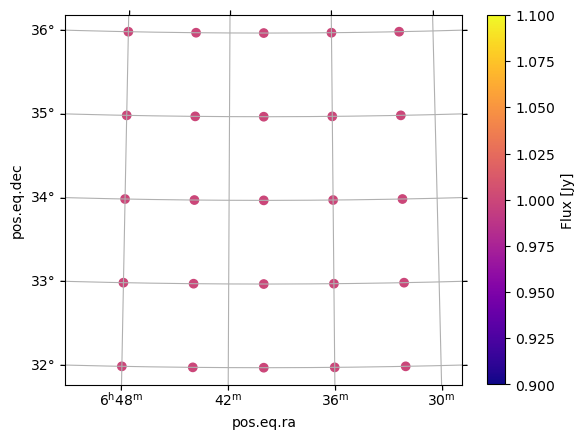

In [39]:
# grid_srcs = False
grid_srcs = True

# Read in and plot the sky model
# sky = SkyModel.sky_test()
if grid_srcs:
    ras = obs["phase_centre"][0] + np.linspace(-obs["fov"]/2, obs["fov"]/2, 5)
    decs = obs["phase_centre"][1] + np.linspace(-obs["fov"]/2, obs["fov"]/2, 5)
    ra_arr, dec_arr = np.meshgrid(ras, decs)
    
    sky = SkyModel()
    sky_data = np.zeros((ra_arr.size, SkyModel.SOURCES_COLS))
    sky_data[:, 0] = ra_arr.flatten()
    sky_data[:, 1] = dec_arr.flatten()
    sky_data[:, 2] = 1
    sky.add_point_sources(sky_data)
else:
    # Sky Model if you want ONE POINT SOURCE ONLY
    sky = SkyModel()
    sky_data = np.array([[*obs["phase_centre"], 1]])
    sky.add_point_sources(sky_data)

sky.explore_sky(phase_center=obs["phase_centre"], wcs_enabled=True, cfun=lambda x: x, cbar_label="Flux [Jy]")

In [40]:
# Simulation settings that are the same for OSKAR and RASCIL
observation = Observation(
    phase_centre_ra_deg=obs["phase_centre"][0],
    phase_centre_dec_deg=obs["phase_centre"][1],
    start_date_and_time=obs["start_time"],
    length=obs["obs_length"],
    number_of_time_steps=obs["n_time"],
    start_frequency_hz=obs["start_freq"],
    frequency_increment_hz=obs["chan_width"],
    number_of_channels=obs["n_freq"],
)

In [41]:
# `sim-vis` which is used for the RFI simulation relies on data from SpaceTrack service.
# It needs a login with username and password. Thus, we must provide the login as
# a .yaml file.

credentials_filename = "my_test_credentials.yaml"
# with open(credentials_filename, "w") as f:
#     f.write("username: <add your username>\n")
#     f.write("password: <add ypur password>\n")


In [42]:
# The class `RFISignal` controls the simulation of RFI sources
rfi_signal = RFISignal(credentials_filename)
rfi_signal.set_rfi_flux_scale(obs["rfi_flux_scale"])
rfi_signal.set_satellites(sat_names=None, norad_ids=obs["norad_ids"])

Creating /tmp/karabo-STM-karabo-PvjXQIF7ox/tabsim-files-8Ly8DlmakJ for working directory for sim-vis


In [43]:
simulation = InterferometerSimulation(
    channel_bandwidth_hz=obs["chan_width"],
    time_average_sec=obs["int_time"],
    ignore_w_components=False,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    use_dask=False,
    station_type="Isotropic beam",  # This is only used by OSKAR (beam setting in OSKAR)
)

In [44]:
output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="rfi-contaminated-",
        purpose="Example satellite RFI simulation",
    )
)

Creating /tmp/karabo-STM-karabo-PvjXQIF7ox/rfi-contaminated-I7vKtWj0YE for Example satellite RFI simulation


In [45]:
#### OSKAR SIMULATION
# Load the telescope (VLA D configuration [compact - max 2 km])
telescope = Telescope.constructor("VLA", VLAVersions.D, backend=SimulatorBackend.OSKAR)
# telescope = Telescope.constructor("EDA2", backend=SimulatorBackend.OSKAR)

visibility = simulation.run_simulation(
    telescope=telescope,
    sky=sky,
    observation=observation,
    backend=SimulatorBackend.OSKAR,
    primary_beam=None,
    visibility_format="MS",
    visibility_path=os.path.join(output_base_directory, "OSKAR.MS"),
    rfi_signals=rfi_signal
)

Matched path /tmp/karabo-STM-karabo-PvjXQIF7ox/rfi-contaminated-I7vKtWj0YE/OSKAR.MS to format MS
Saved visibility to /tmp/karabo-STM-karabo-PvjXQIF7ox/rfi-contaminated-I7vKtWj0YE/OSKAR.MS
{'telescope': {'name': 'vla', 'dish_d': 1.0, 'elevation': 0.00016802196474896108, 'itrf_path': '/home/karabo/.cache/karabo-LTM-karabo-ulUyVcEAYb/tabsim-files-4o4CteTd8v/vla.itrf.txt', 'latitude': 34.07872084786497, 'longitude': -107.6183318164056, 'n_ant': 27}, 'observation': {'target_name': 'pointing_100.00_34.00', 'ra': 100, 'dec': 34, 'n_int': 10, 'SEFD': 0, 'auto_corrs': False, 'no_w': False, 'random_seed': 12345, 'chan_width': 1000000.0, 'int_time': 2.0, 'n_freq': 1, 'n_time': 20, 'start_freq': 15000000.0, 'start_time_isot': '2023-02-22T04:12:52.000'}, 'rfi_sources': {'tle_satellite': {'max_n_sat': None, 'sat_names': [], 'norad_ids': [46038], 'spacetrack_path': 'my_test_credentials.yaml', 'tle_dir': '/home/karabo/.cache/karabo-LTM-karabo-ulUyVcEAYb/tabsim-files-4o4CteTd8v/tles', 'norad_spec_model

In [46]:
xyz = (
    rfi_signal.xds.rfi_tle_sat_xyz.data[:, :: rfi_signal.xds.n_int_samples]
    - rfi_signal.xds.ants_xyz.data.mean(axis=1)[None, :: rfi_signal.xds.n_int_samples, :]
)
d_f = 2 * telescope.max_baseline()**2 / (3e8 / obs["start_freq"])
R = np.linalg.norm(xyz[0], axis=-1).compute()
print(f"Average satellite distance   : {R.mean()/1e3:.0f} km")
print(f"Near-field boundary distance : {d_f/1e3:.0f} km")

Average satellite distance   : 560 km
Near-field boundary distance : 578 km


In [47]:
# Set Imaging parameters
fov = np.deg2rad(60)
imaging_cellsize = np.deg2rad(telescope.ang_res(obs["start_freq"], telescope.max_baseline())/3600)
imaging_npixel = 2 * int(fov / imaging_cellsize / 2)
print(f"Image size : ({imaging_npixel}x{imaging_npixel})")


Image size : (124x124)


Creating /tmp/karabo-STM-karabo-PvjXQIF7ox/WSClean-dirty-fILEHyGPhS for Disk cache for WSClean dirty images
WSClean command: cd /tmp/karabo-STM-karabo-PvjXQIF7ox/WSClean-dirty-fILEHyGPhS && OPENBLAS_NUM_THREADS=1 wsclean -size 124 124 -scale 0.4762790547229444deg /tmp/karabo-STM-karabo-PvjXQIF7ox/rfi-contaminated-I7vKtWj0YE/OSKAR.MS
WSClean output:
[
WSClean version 3.5 (2024-07-30)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  15-16 (1)
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-karabo-PvjXQIF7ox/rfi-contaminated-I7vKtWj0YE/OSKAR.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-7020; 7020 rows)
 == Constructing image ==
Detected 23.4 GB of system memory, usage not limited.

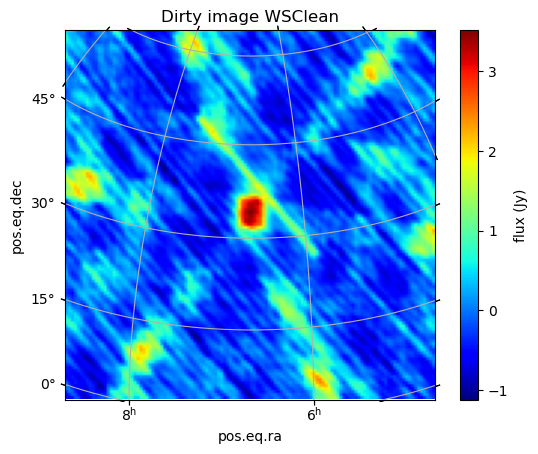

In [48]:
# Imaging with WSClean
imager_single = WscleanDirtyImager(
    WscleanDirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
)

dirty_image = imager_single.create_dirty_image(visibility)
img_fig = dirty_image.plot(title="Dirty image WSClean")

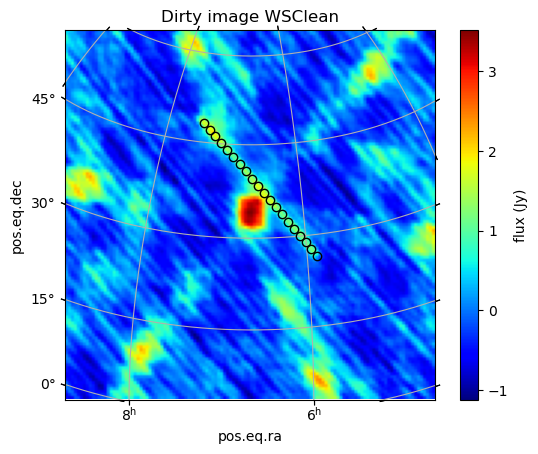

In [49]:
radec = rfi_signal.get_satellite_radec()
ax = img_fig.axes[0]                 # or grab the specific WCSAxes you want
world = ax.get_transform('world')  # 'world' = RA/Dec in the axis' native frame
for i in range(len(radec)):
        ax.plot(radec[i,:,0], radec[i,:,1], 'o', alpha=1, ms=6, mfc='none', mec='black', transform=world) 

img_fig


In [50]:
imager_multi = WscleanDirtyImager(
    WscleanDirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
        intervals_out=obs["n_time"],
    )
)
dirty_fits_fps = imager_multi.create_dirty_image_series(visibility)

Creating /tmp/karabo-STM-karabo-PvjXQIF7ox/WSClean-dirty-99VCqCSxXe for Disk cache for WSClean dirty images
WSClean command: cd /tmp/karabo-STM-karabo-PvjXQIF7ox/WSClean-dirty-99VCqCSxXe && OPENBLAS_NUM_THREADS=1 wsclean -size 124 124 -scale 0.4762790547229444deg -intervals-out 20 /tmp/karabo-STM-karabo-PvjXQIF7ox/rfi-contaminated-I7vKtWj0YE/OSKAR.MS
WSClean output:
[
WSClean version 3.5 (2024-07-30)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  15-16 (1)
Counting number of scans... DONE (20)
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-karabo-PvjXQIF7ox/rfi-contaminated-I7vKtWj0YE/OSKAR.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-351; 351 rows)
 == Constructing image ==

In [51]:
import os
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from typing import List

import warnings
from astropy.wcs import WCS
from astropy.wcs import FITSFixedWarning


def make_gif(fits_files: List[str], output_gif: str):
    # List to store image frames
    frames = []

    # Normalize the data for display
    data = [fits.getdata(fits_file)[0, 0] for fits_file in fits_files]
    vmin, vmax = np.percentile(data, [0.1, 99.9])

    for i, fits_file in enumerate(fits_files):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FITSFixedWarning)
            wcs = WCS(
                fits.open(fits_file)[0].header
            ).celestial  # Get the celestial WCS (RA/Dec)

        # Create figure with WCS projection
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection=wcs)
        im = ax.imshow(data[i], cmap="gray", vmin=vmin, vmax=vmax, origin="lower")

        # Sky grid
        ax.coords.grid(True, color="blue", ls="dotted")
        ax.coords[0].set_axislabel("Right Ascension")
        ax.coords[1].set_axislabel("Declination")

        # Inset colorbar
        cax = ax.inset_axes([0.87, 0.05, 0.03, 0.4])  # adjust as needed

        # Create colorbar
        cb = ax.figure.colorbar(im, cax=cax, orientation="vertical")
        cb.ax.tick_params(labelsize=6)

        # Save to temp image
        temp_path = f"temp_frame_{i:03d}.png"
        plt.savefig(temp_path, bbox_inches="tight", pad_inches=0)
        plt.close(fig)

        frame = Image.open(temp_path).convert("P")
        frames.append(frame)
        os.remove(temp_path)

    # Save as animated GIF
    frames[0].save(
        output_gif,
        save_all=True,
        append_images=frames[1:],
        duration=200,  # milliseconds per frame
        loop=0,  # infinite loop
    )

    print(f"GIF saved as {output_gif}")

In [52]:
make_gif(dirty_fits_fps, "test_rfi_sat.gif")

GIF saved as test_rfi_sat.gif
